In [28]:
import matplotlib.pyplot as plt
import glob
import os
import json
import numpy as np
import pandas as pd
from utils import load_m4_data, load_m3_data, DeTrendSeason
from transformation import Transformation

plt.rcParams["figure.figsize"] = (21, 10)
plt.rcParams["font.size"] = 24
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["legend.handlelength"] = 2

In [29]:
# datasets = load_m4_data(min_length=1000, max_length=1500, n_set=64, freq='Daily')
# for name, series in datasets.items():
#     plt.plot(series)
#     plt.title(name)
#     plt.show()

In [30]:
df = pd.read_excel('./Dataset/M3c.xls', sheet_name='M3Month')
df.set_index(['Series'], inplace=True)
cate = pd.DataFrame(df.loc[:, 'Category'])

In [31]:
bad = ['D173', 'D50', 'D56', 'D86', 'D48', 'D49']
bad = []

def load_json(base_dir='./json_data', target_file=None):
    datas = []
    if not target_file:
        filepath = '/'.join([base_dir, '*.json'])
        target_file = max(glob.glob(filepath), key = os.path.getctime)
    print(target_file)
    with open(target_file, 'r') as file:
        for line in file.readlines():
            data = json.loads(line)
            if data['name'] in bad:
                continue
            datas.append(data)

    return datas

In [32]:
# datas = load_json(target_file='./json_data/m3_96_series.json')
# datas = load_json(target_file='./json_data/m3_48_log.json')
# datas = load_json(target_file='./json_data/m4_55_log_tmp.json')

# datas = load_json(target_file='./json_data/results_1657795470.json') ## m3 print log return prediction
# datas = load_json(target_file='./json_data/total_m3.json')
# datas = load_json(target_file='./json_data/test_gru_naive.json')
# datas = load_json(target_file='./json_data/m3_100_log.json')
# datas = load_json(target_file='./json_data/test_m3.json')
datas = load_json(target_file='./json_data/m3_1043_detrend_v1_0722.json')
# datas = load_json(target_file='./json_data/m3_1043_origin_v1_0724.json')

./json_data/m3_1043_detrend_v1_0722.json


In [33]:
from utils import Performance_metrics
p = Performance_metrics()

count = 0
for data in datas:
    # if data['name'] != 'N1679':
    #     continue
    test = np.array(data['test_y']).ravel()
    for key in ['untransformed', 'transformed']:
        for model_name, model_val in data[key].items():
            # s = p.one_measure(scoring='symmetric_mean_absolute_percentage_error', true_y=test, pred_y=model_val['prediction'])
            # print(f'{model_name} {key}: {s}')
            if model_name == 'RandomForestRegressor':
                if data['untransformed'][model_name]['additional_info']['fitted_params']['n_estimators'] == 10:
                    count += 1
            else:
                continue
            # print(model_name, data['untransformed'][model_name]['additional_info']['fitted_params'])
    break

# from utils import Performance_metrics

# for data in datas:

#     test = np.array(data['test_y']).ravel()
#     for key in ['untransformed', 'transformed']:
#         for model_name, model_val in data[key].items():
#             print(f'{model_name} {key}')
#             p = Performance_metrics(true_y=test, predict_y=model_val['prediction'])
#             p.measuring(model_name=model_name, dataset_name=data['name'])
#             print('=='*20)
    

In [34]:
def plot_prediction(datas, model, dataset_name='N1725', n_dataset=1, only_test=True):
    t = Transformation(datas)
    n_dataset_list = set()
    base = True
    df = pd.DataFrame()

    for data in datas:

        if model not in data['untransformed']:
            return

        if dataset_name and data['name'] != dataset_name:
            continue
        if len(n_dataset_list) < n_dataset:
            n_dataset_list.add(data['name'])
        if data['name'] not in n_dataset_list:
            continue

        train = np.array(data['train_y']).ravel()
        test = np.array(data['test_y']).ravel()

        if only_test:
            test_time_idx = range(len(test))[-200:]
        else:
            train_time_idx = range(len(train)+len(test))[:len(train)]
            test_time_idx = range(len(train)+len(test))[len(train):]

        if base:
            if not only_test:
                plt.plot(train_time_idx, train, linewidth=8, alpha=0.5, label='train data')
                plt.plot(train_time_idx, t.dwt(train, wavelet=data['transformed'][model]['threshold']), linewidth=8, alpha=0.5, label='train data (trans)')
            plt.plot(test_time_idx, test[-200:], label='test data', linewidth=8, alpha=0.5)
            plt.title(f'Series: {data["name"]}, Model: {model}')
            plt.legend()
            base = False

        pred = data['untransformed'][model]['prediction'][-200:]
        label = f"untransformed series, Lag: {data['untransformed'][model]['lags']}, SMAPE: {data['untransformed'][model]['symmetric_mean_absolute_percentage_error']}, RMSE: {data['untransformed'][model]['root_mean_squared_error']}"
        plt.plot(test_time_idx, pred, label=label, linewidth=5, alpha=0.5)
        
        pred = data['transformed'][model]['prediction'][-200:]
        label = f"threshold: {data['transformed'][model]['threshold']}, Lag: {data['transformed'][model]['lags']}, SMAPE: {data['transformed'][model]['symmetric_mean_absolute_percentage_error']}, RMSE: {data['transformed'][model]['root_mean_squared_error']}"
        plt.plot(test_time_idx, pred, label=label, linewidth=2.5, alpha=0.8)
        
        plt.legend()

    plt.tight_layout()
    plt.show()

In [35]:
def plot_log_prediction(datas, model, dataset_name='', n_dataset=1, only_test=True):
        n_dataset_list = set()
        base = True
        df = pd.DataFrame()

        for data in datas:
            if 'logr_train_y' not in data:
                return

            if model not in data['untransformed']:
                return

            if dataset_name and data['name'] != dataset_name:
                continue
            if len(n_dataset_list) < n_dataset:
                n_dataset_list.add(data['name'])
            if data['name'] not in n_dataset_list:
                continue

            train = np.array(data['logr_train_y']).ravel()
            test = np.array(data['logr_test_y']).ravel()

            if only_test:
                test_time_idx = range(len(test))[-200:]
            else:
                train_time_idx = range(len(train)+len(test))[:len(train)]
                test_time_idx = range(len(train)+len(test))[len(train):]

            if base:
                if not only_test:
                    plt.plot(train_time_idx, train, linewidth=8, alpha=0.5)
                plt.plot(test_time_idx, test[-200:], label='test data', linewidth=8, alpha=0.5)
                plt.title(f'[Log Return] Series: {data["name"]}, Model: {model}')
                plt.legend()
                base = False

            pred = np.array(data['untransformed'][model]['log_prediction'][-200:]).ravel()
            label = f"untransformed series, Lag: {data['untransformed'][model]['lags']}, SMAPE: {data['untransformed'][model]['symmetric_mean_absolute_percentage_error']}, RMSE: {data['untransformed'][model]['root_mean_squared_error']}"
            plt.plot(test_time_idx, pred, label=label, linewidth=5, alpha=0.5)
            
            pred = np.array(data['transformed'][model]['log_prediction'][-200:]).ravel()
            label = f"threshold: {data['transformed'][model]['threshold']}, Lag: {data['transformed'][model]['lags']}, SMAPE: {data['transformed'][model]['symmetric_mean_absolute_percentage_error']}, RMSE: {data['transformed'][model]['root_mean_squared_error']}"
            plt.plot(test_time_idx, pred, label=label, linewidth=2.5, alpha=0.8)
            
            plt.legend()


        plt.tight_layout()
        plt.show()

In [36]:
def smape_result():
    smape_df = pd.DataFrame()
    info = dict()
    d = ['N1679', 'N1680', 'N1681', 'N1682', 'N1683', 'N1684', 'N1685', 'N1686',
       'N1687', 'N1688', 'N1689', 'N1690', 'N1691', 'N1692', 'N1693', 'N1694',
       'N1695', 'N1696', 'N1697', 'N1698', 'N1699', 'N1700', 'N1701', 'N1702',
       'N1703', 'N1704', 'N1705', 'N1706', 'N1707', 'N1708', 'N1709', 'N1710',
       'N1711', 'N1712', 'N1713', 'N1714', 'N1715', 'N1716', 'N1717', 'N1718',
       'N1719', 'N1720', 'N1721', 'N1722', 'N1723', 'N1724', 'N1725', 'N1726',]

    #    ['D1661', 'D1662', 'D1663', 'D1664', 'D1665', 'D1666', 'D1667', 'D1668',
    #    'D1669', 'D1670', 'D201', 'D202', 'D203', 'D204', 'D205', 'D206',
    #    'D207', 'D208', 'D209', 'D210', 'D2121', 'D2122', 'D2123', 'D2124',
    #    'D2125', 'D2126', 'D2127', 'D2128', 'D2129', 'D2130', 'D3621', 'D3622',
    #    'D3623', 'D3624', 'D3625', 'D3626', 'D3627', 'D3628', 'D3629', 'D3630',
    #    'D51', 'D52', 'D53', 'D54', 'D55', 'D56', 'D57', 'D58', 'D59', 'D60']
    for data in datas:
        dataset_name = data['name']
        # if dataset_name not in d:
        #     continue
        # if dataset_name not in ['D51', 'D52', 'D53', 'D54', 'D55', 'D56', 'D57', 'D58', 'D59', 'D60']:
        #     continue
        for key in ['untransformed', 'transformed']:
            try:
                for model_name, model_val in data[key].items():
                    if model_name not in info:
                        info[model_name] = dict()
                    info[model_name][key] = model_val['symmetric_mean_absolute_percentage_error']
                    # info[model_name][key] = model_val['root_mean_squared_error']
            except:
                print(dataset_name)
                continue
        reform = {(outerKey, innerKey): values for outerKey, innerDict in info.items() for innerKey, values in dict(innerDict).items()}
        # print(reform)
        df = pd.DataFrame(reform, index=[dataset_name])
        # df.columns = pd.MultiIndex.from_product([[dataset_name], df.columns])
        # return df
        # df = pd.DataFrame.from_dict(info, orient='columns')
        # df.columns = pd.MultiIndex.from_product([[dataset_name], df.columns])
        # return df
        smape_df = pd.concat([smape_df, df], axis=0)
    # smape_df.drop(index=['D173', 'D50', 'D56', 'D86', 'D48'], inplace=True)
    smape_df.loc[('Total',)] = smape_df.sum()
    return smape_df.sort_index()

smape_df = smape_result()

ccate = pd.concat([smape_df, cate], axis=1)
ccate.dropna(how='any', inplace=True)

# print(smape_df.index)
smape_df.iloc[-1:,]
smape_df

ccate.groupby('Category').mean()
smape_df

ElasticNet                 LinearSVR             KNeighborsRegressor  \
      untransformed transformed untransformed transformed       untransformed   
N1679         0.339       0.318         0.389       0.418               0.367   
N1680         0.377       0.356         0.405       0.454               0.394   
N1681         0.260       0.297         0.570       0.396               0.276   
N1682         0.111       0.113         0.108       0.112               0.110   
N1683         0.117       0.114         0.109       0.119               0.131   
...             ...         ...           ...         ...                 ...   
N2776         0.001       0.001         0.001       0.002               0.003   
N2777         0.003       0.003         0.004       0.003               0.003   
N2780         1.640       1.635         1.666       1.646               1.619   
N2783         0.296       0.293         0.302       0.361               0.306   
Total       165.999     164.758       191.247     185.690             169.836   

                  RandomForestRegressor              MLPRegressor              \
      transformed         untransformed transformed untransformed transformed   
N1679       0.347                 0.582       0.432         0.342       0.310   
N1680       0.364                 0.506       0.431         0.376       0.384   
N1681       0.335                 0.347       0.367         0.472       0.303   
N1682       0.106                 0.119       0.111         0.110       0.108   
N1683       0.115                 0.144       0.122         0.082       0.118   
...           ...                   ...         ...           ...         ...   
N2776       0.003                 0.002       0.002         0.001       0.002   
N2777       0.004                 0.004       0.003         0.003       0.003   
N2780       1.634                 1.629       1.652         1.732       1.620   
N2783       0.325                 0.457       0.404         0.302       0.302   
Total     169.613               191.318     185.361       173.947     173.423   

            AutoETS             NaiveForecaster              
      untransformed transformed   untransformed transformed  
N1679         0.343       0.303           0.329       0.329  
N1680         0.366       0.376           0.410       0.448  
N1681         0.257       0.250           0.233       0.224  
N1682         0.109       0.110           0.111       0.118  
N1683         0.125       0.128           0.109       0.117  
...             ...         ...             ...         ...  
N2776         0.001       0.001           0.001       0.001  
N2777         0.003       0.003           0.003       0.003  
N2780         1.628       1.629           1.633       1.637  
N2783         0.297       0.296           0.440       0.440  
Total       159.564     159.440         166.102     168.897  

[1044 rows x 14 columns]

In [37]:
ccate.groupby('Category').mean()

,"(ElasticNet, untransformed)","(ElasticNet, transformed)","(LinearSVR, untransformed)","(LinearSVR, transformed)","(KNeighborsRegressor, untransformed)","(KNeighborsRegressor, transformed)","(RandomForestRegressor, untransformed)","(RandomForestRegressor, transformed)","(MLPRegressor, untransformed)","(MLPRegressor, transformed)","(AutoETS, untransformed)","(AutoETS, transformed)","(NaiveForecaster, untransformed)","(NaiveForecaster, transformed)"
Category,,,,,,,,,,,,,,
DEMOGRAPHIC,0.060044,0.061122,0.072133,0.066300,0.066244,0.066111,0.067322,0.070467,0.062367,0.066744,0.062122,0.063100,0.060967,0.061378
FINANCE,0.164430,0.167198,0.185529,0.192455,0.174273,0.173066,0.176934,0.176603,0.168107,0.178388,0.161033,0.160893,0.169289,0.171248
INDUSTRY,0.196955,0.198517,0.217057,0.214171,0.204222,0.205964,0.215574,0.215315,0.201991,0.204429,0.193051,0.194556,0.199817,0.201943
MACRO,0.071027,0.071313,0.082463,0.081147,0.078447,0.078177,0.077877,0.077137,0.073667,0.073620,0.069793,0.069920,0.072073,0.072523
MICRO,0.263294,0.251766,0.321416,0.298305,0.250365,0.247330,0.338147,0.308391,0.287289,0.272832,0.240299,0.236574,0.253284,0.261782
OTHER,0.968000,0.964000,0.984000,1.003500,0.962500,0.979500,1.043000,1.028000,1.017000,0.961000,0.962500,0.962500,1.036500,1.038500


In [38]:
remain = (smape_df[smape_df.columns[0]] > smape_df[smape_df.columns[1]] ) & (smape_df[smape_df.columns[2]] > smape_df[smape_df.columns[3]] ) & (smape_df[smape_df.columns[4]] > smape_df[smape_df.columns[5]] ) & (smape_df[smape_df.columns[6]] > smape_df[smape_df.columns[7]] ) & (smape_df[smape_df.columns[8]] > smape_df[smape_df.columns[9]] ) & (smape_df[smape_df.columns[10]] > smape_df[smape_df.columns[11]] )
smape_df[remain]

ElasticNet                 LinearSVR             KNeighborsRegressor  \
      untransformed transformed untransformed transformed       untransformed   
N1701         0.322       0.271         0.776       0.302               0.302   
N1702         0.415       0.407         0.437       0.402               0.427   
N1735         0.296       0.235         0.624       0.234               0.216   
N1737         0.378       0.377         0.556       0.392               0.283   
N1748         0.367       0.284         0.562       0.463               0.369   
N1757         0.248       0.182         0.301       0.243               0.205   
N1761         0.330       0.184         0.490       0.184               0.155   
N1762         0.127       0.119         0.231       0.142               0.143   
N1766         1.286       1.276         1.326       1.270               1.319   
N1780         0.382       0.363         0.418       0.410               0.413   
N1782         0.330       0.318         0.324       0.268               0.325   
N1830         0.325       0.319         0.716       0.372               0.434   
N1848         0.053       0.044         0.053       0.036               0.041   
N1869         0.049       0.043         0.056       0.044               0.053   
N1906         0.654       0.650         0.669       0.654               0.649   
N1958         0.096       0.091         0.094       0.084               0.105   
N2135         0.102       0.099         0.114       0.105               0.107   
N2176         0.189       0.184         0.162       0.160               0.290   
N2240         0.026       0.024         0.029       0.027               0.029   
N2491         0.267       0.264         0.348       0.314               0.291   
N2493         0.120       0.119         0.154       0.140               0.130   
N2636         0.078       0.073         0.097       0.086               0.082   
N2638         0.083       0.077         0.180       0.152               0.118   
Total       165.999     164.758       191.247     185.690             169.836   

                  RandomForestRegressor              MLPRegressor              \
      transformed         untransformed transformed untransformed transformed   
N1701       0.232                 0.414       0.343         0.545       0.405   
N1702       0.360                 0.952       0.797         0.421       0.415   
N1735       0.200                 1.067       0.386         0.428       0.373   
N1737       0.274                 0.601       0.217         0.409       0.396   
N1748       0.362                 0.516       0.402         0.609       0.372   
N1757       0.199                 0.401       0.344         0.244       0.229   
N1761       0.148                 0.337       0.278         0.302       0.200   
N1762       0.127                 0.237       0.202         0.197       0.188   
N1766       1.291                 1.279       1.249         1.302       1.270   
N1780       0.351                 0.710       0.482         0.376       0.363   
N1782       0.321                 0.363       0.324         0.331       0.314   
N1830       0.370                 0.483       0.444         0.329       0.323   
N1848       0.033                 0.073       0.055         0.091       0.071   
N1869       0.050                 0.075       0.060         0.061       0.051   
N1906       0.640                 0.662       0.656         0.664       0.660   
N1958       0.101                 0.114       0.102         0.100       0.097   
N2135       0.101                 0.135       0.131         0.099       0.098   
N2176       0.212                 0.283       0.242         0.197       0.192   
N2240       0.025                 0.058       0.055         0.030       0.024   
N2491       0.288                 0.278       0.270         0.287       0.277   
N2493       0.127                 0.135       0.134         0.116       0.109   
N2636       0.073                 0.102

[20220725 20:35:51 INFO   ] Loading M3 dataset
100%|██████████| 1399/1399 [00:15<00:00, 90.83it/s] 
[20220725 20:36:07 INFO   ] Get 1043 datasets with length > 100
/Users/nick/opt/anaconda3/envs/afe/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


N1830, ADF: True, KPSS: False, seasonal: True


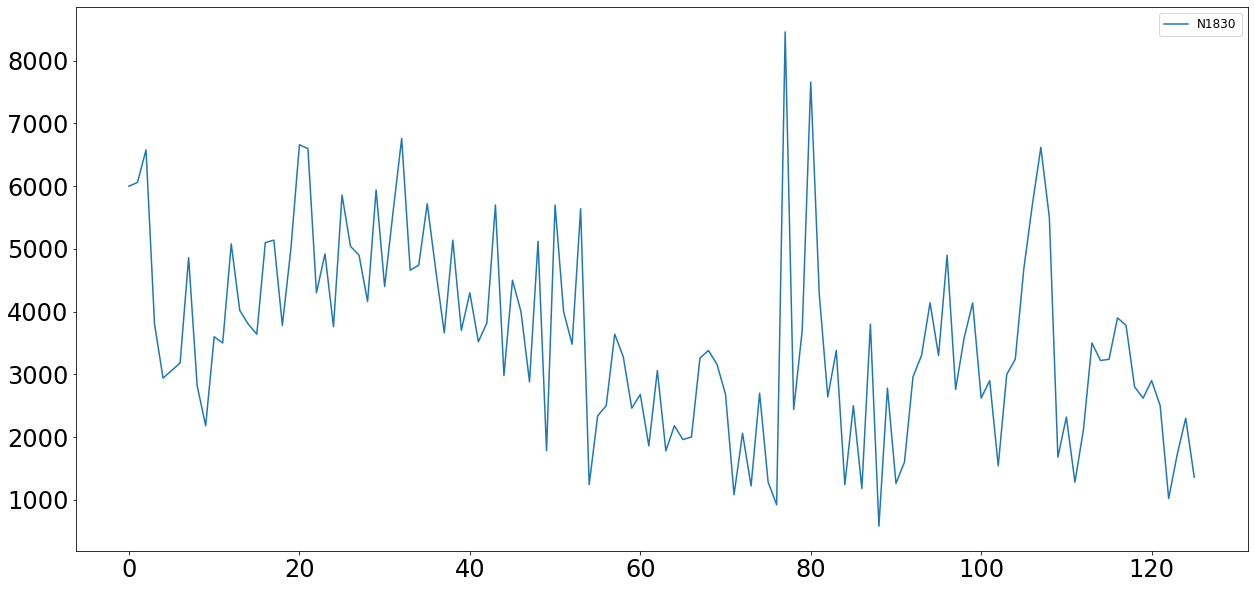

N2493, ADF: False, KPSS: False, seasonal: True


/Users/nick/opt/anaconda3/envs/afe/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


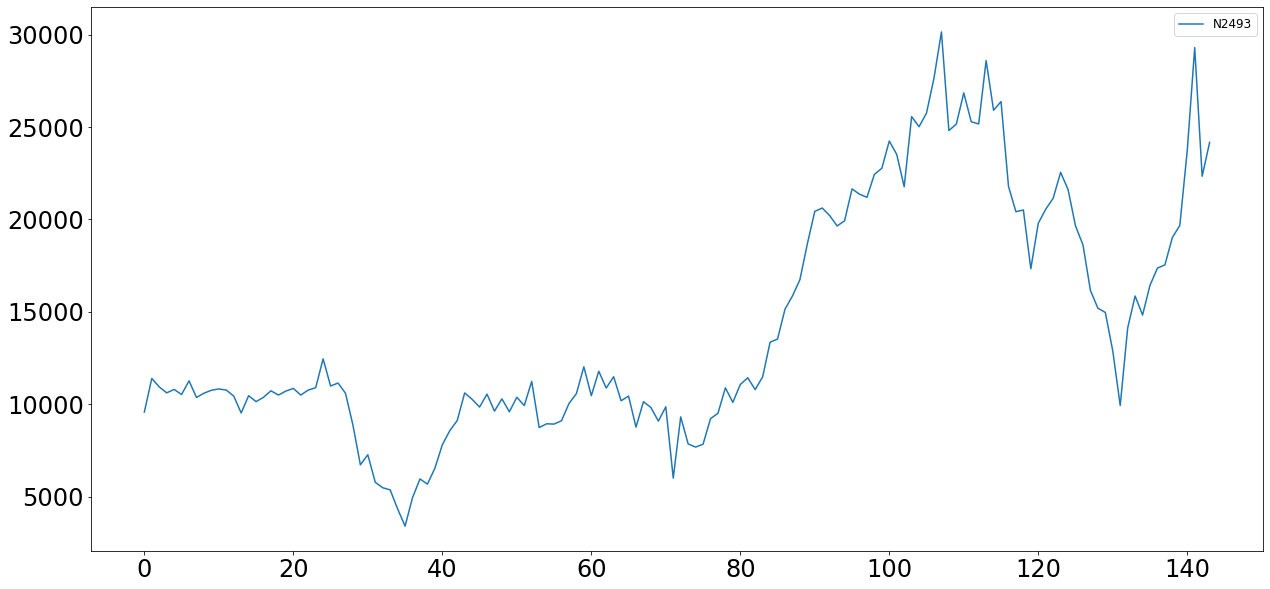

/Users/nick/opt/anaconda3/envs/afe/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


N1735, ADF: False, KPSS: False, seasonal: True


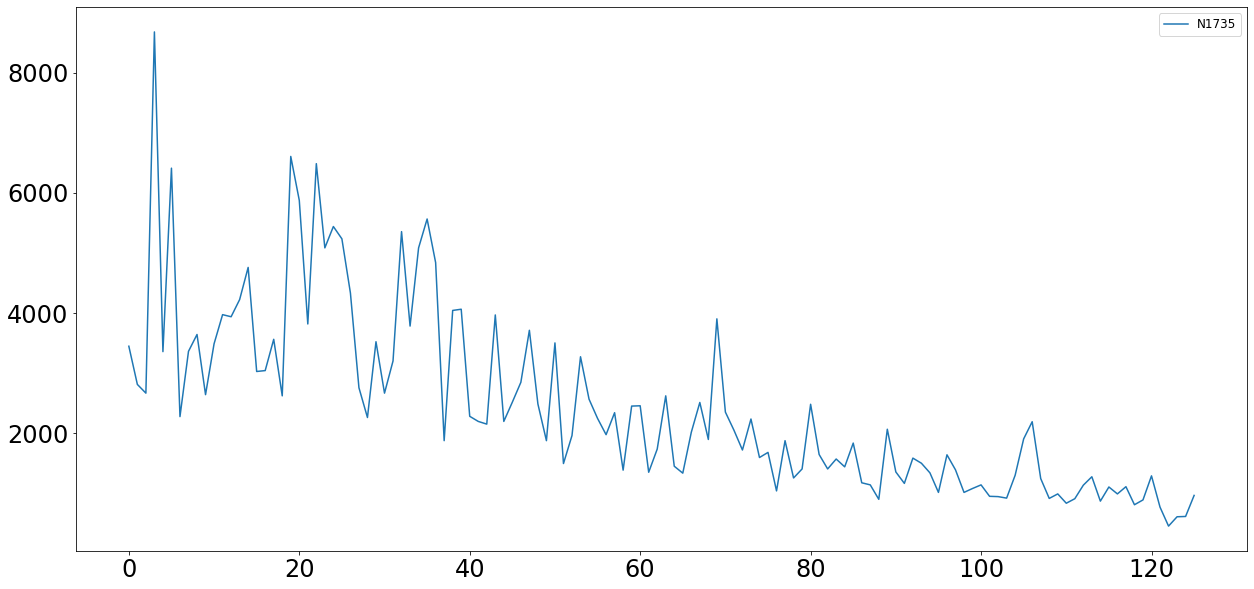

/Users/nick/opt/anaconda3/envs/afe/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


N2135, ADF: False, KPSS: False, seasonal: True


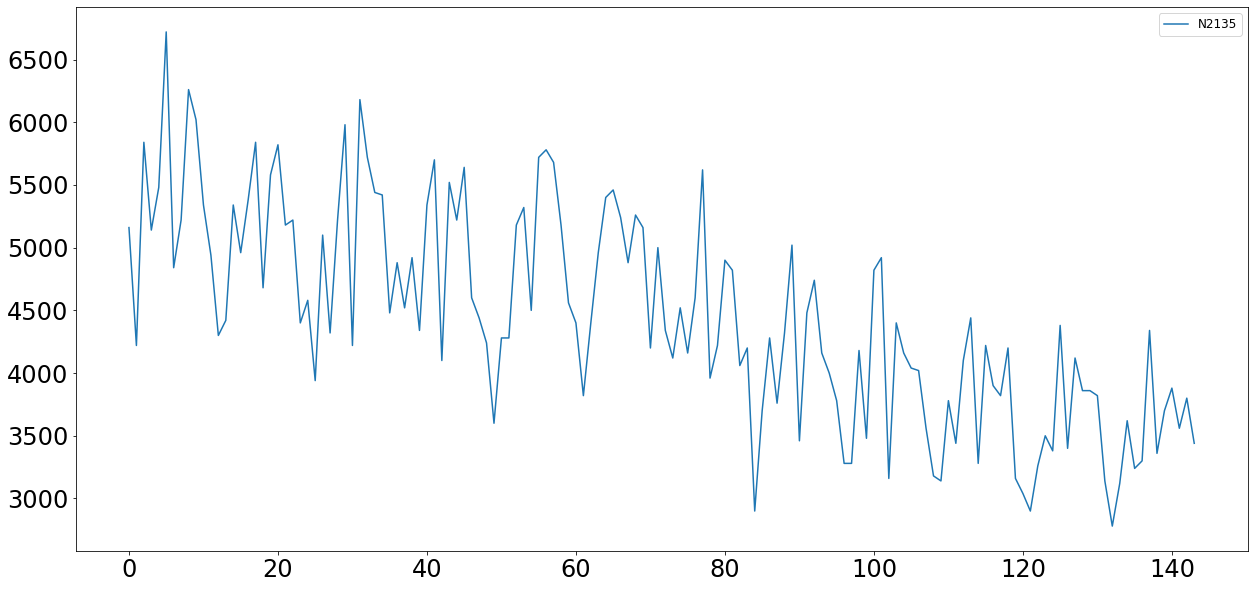

/Users/nick/opt/anaconda3/envs/afe/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


N1702, ADF: False, KPSS: False, seasonal: True


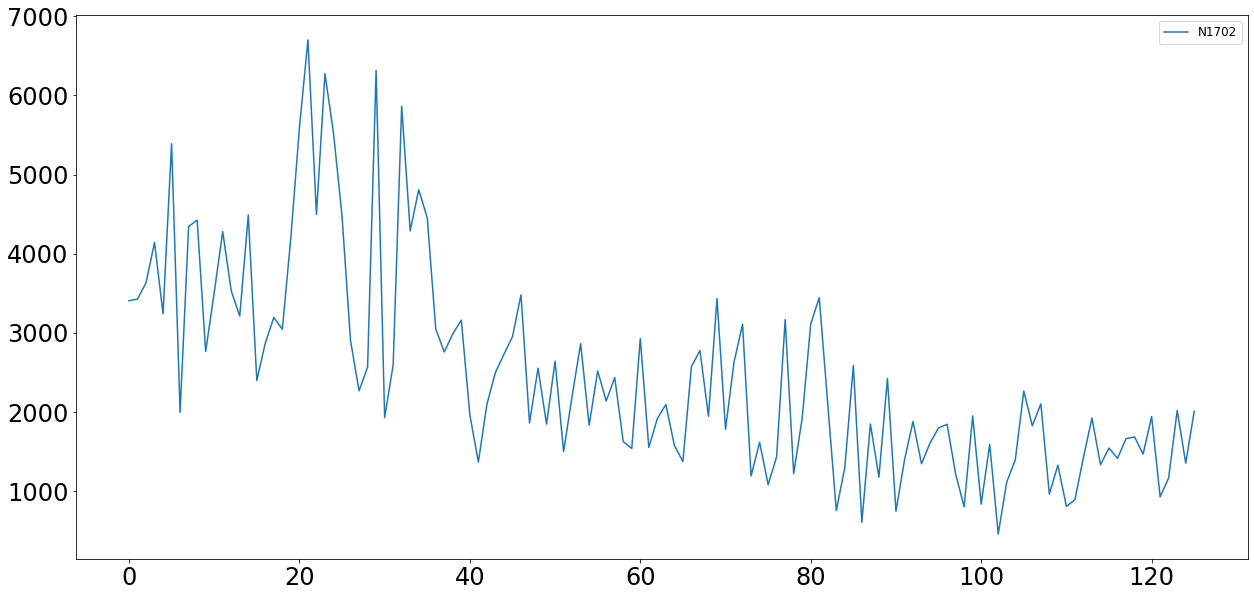

/Users/nick/opt/anaconda3/envs/afe/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


N1906, ADF: False, KPSS: True, seasonal: True


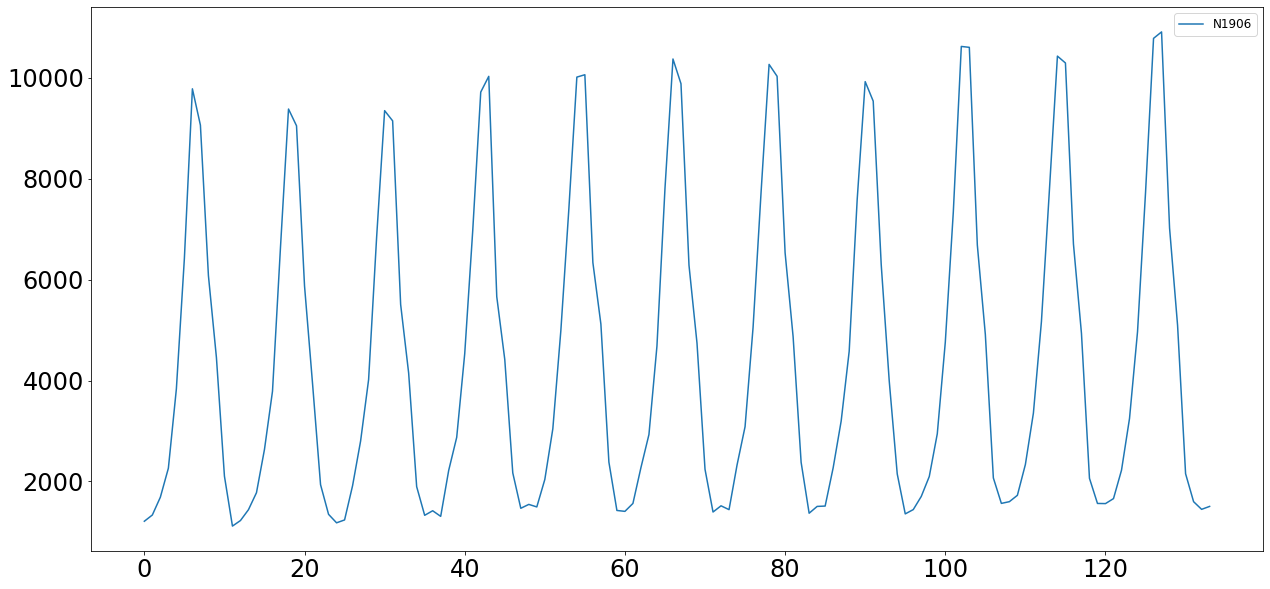

/Users/nick/opt/anaconda3/envs/afe/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


N1780, ADF: False, KPSS: False, seasonal: True


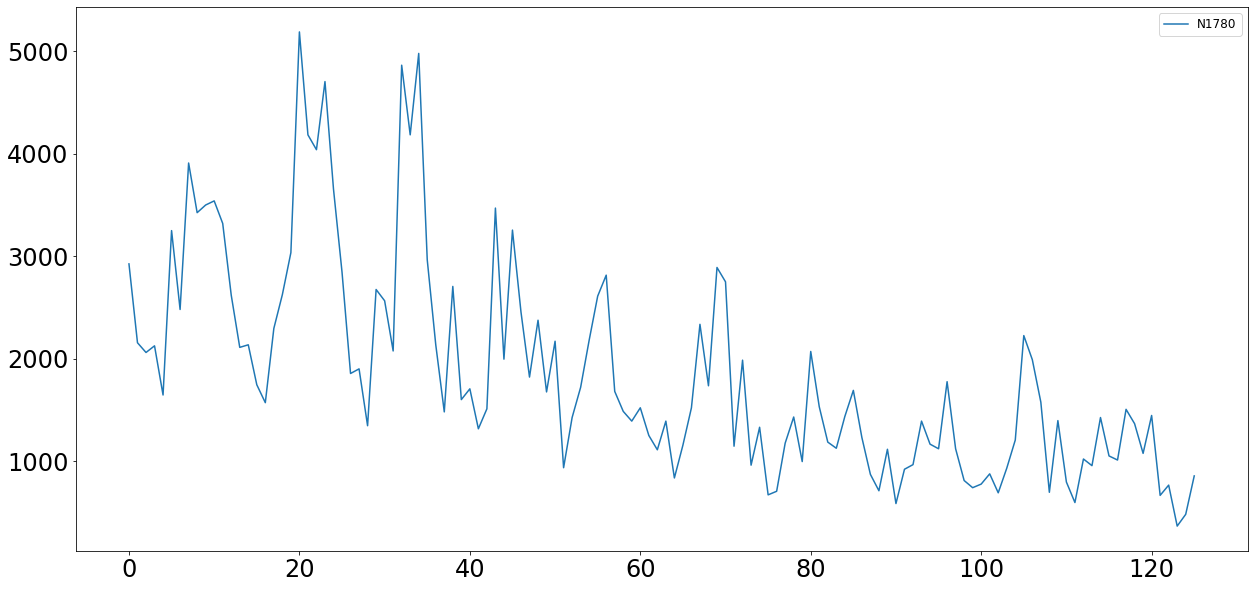

/Users/nick/opt/anaconda3/envs/afe/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


N2491, ADF: False, KPSS: False, seasonal: True


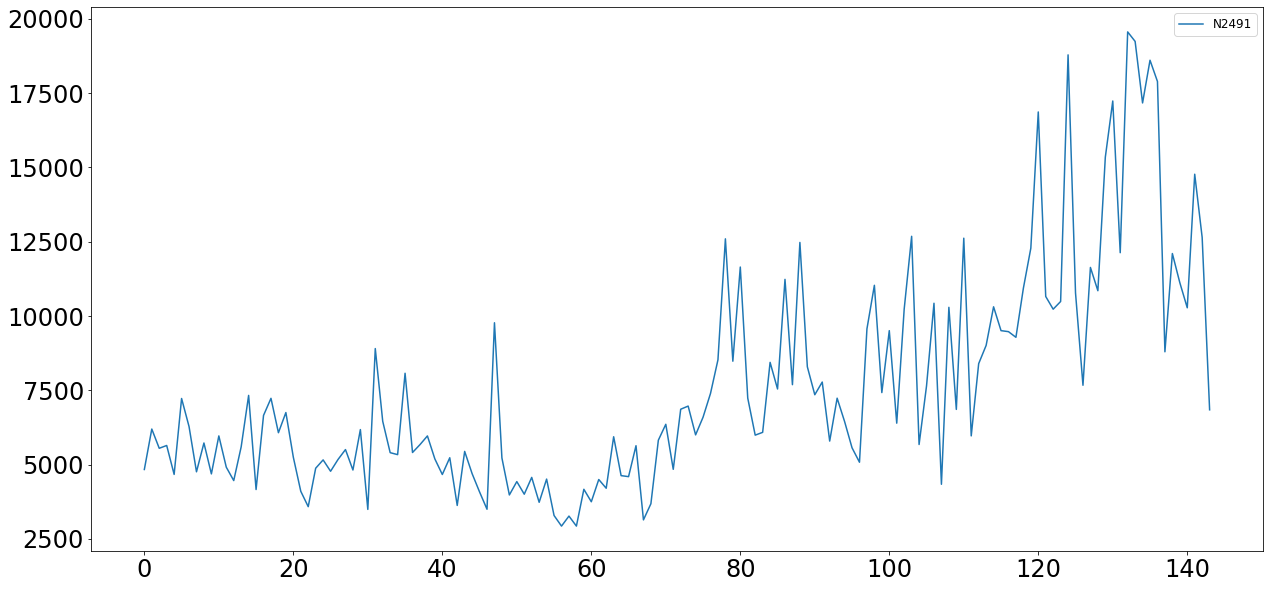

/Users/nick/opt/anaconda3/envs/afe/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


N1761, ADF: False, KPSS: False, seasonal: True


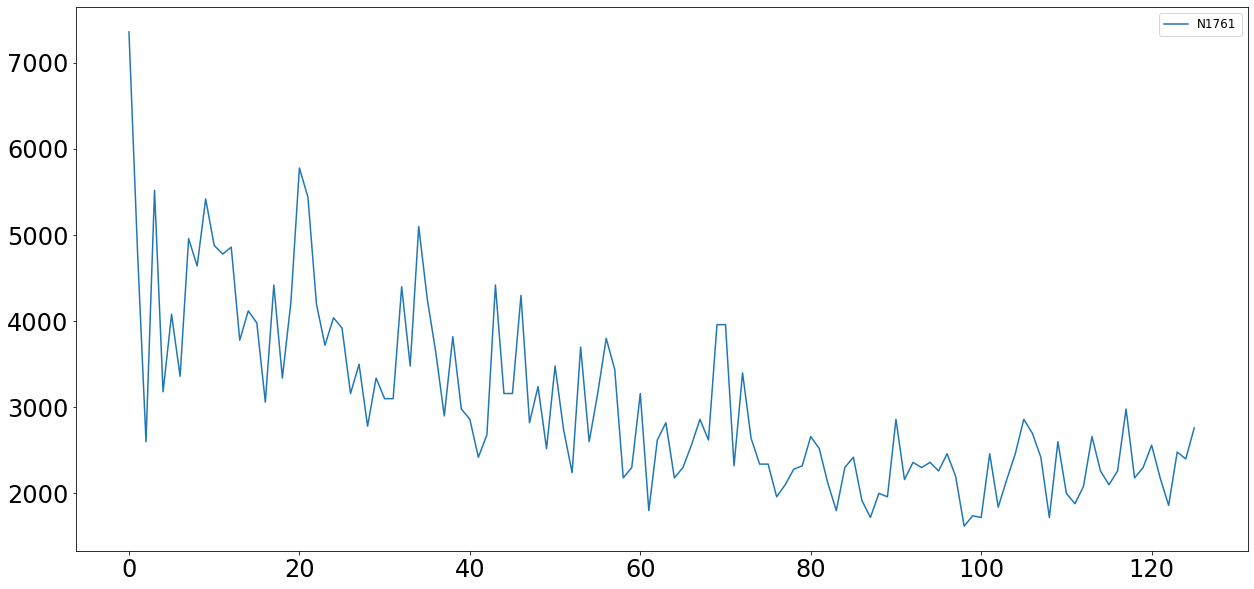

/Users/nick/opt/anaconda3/envs/afe/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


N2176, ADF: True, KPSS: True, seasonal: True


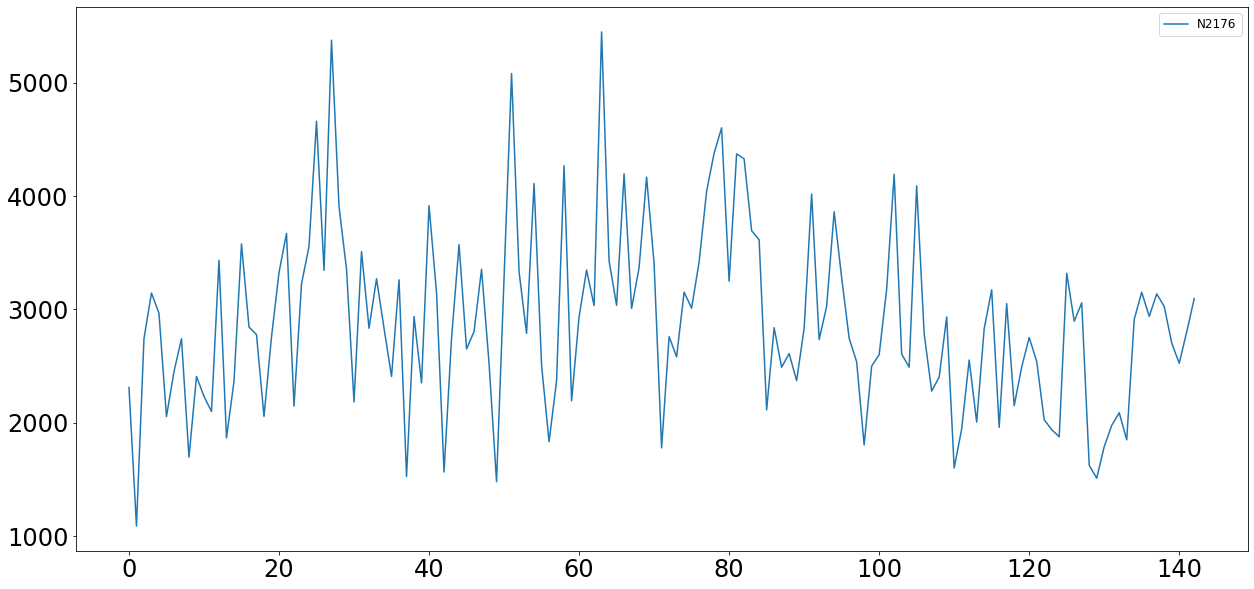

/Users/nick/opt/anaconda3/envs/afe/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


N2636, ADF: False, KPSS: False, seasonal: True


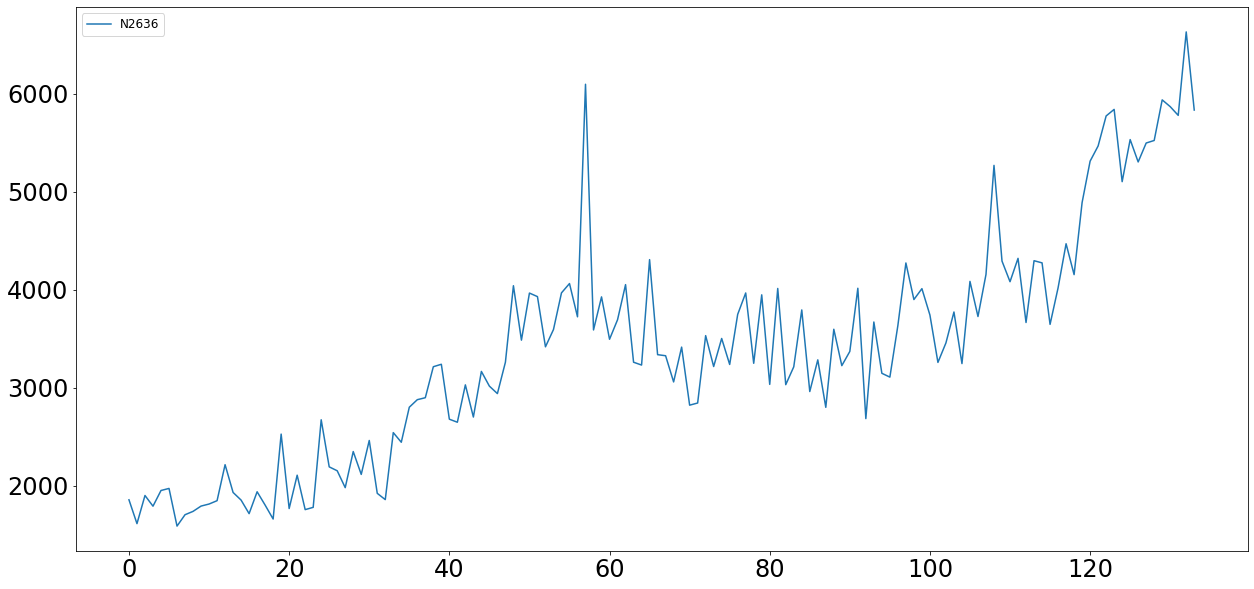

/Users/nick/opt/anaconda3/envs/afe/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


N2240, ADF: False, KPSS: False, seasonal: False


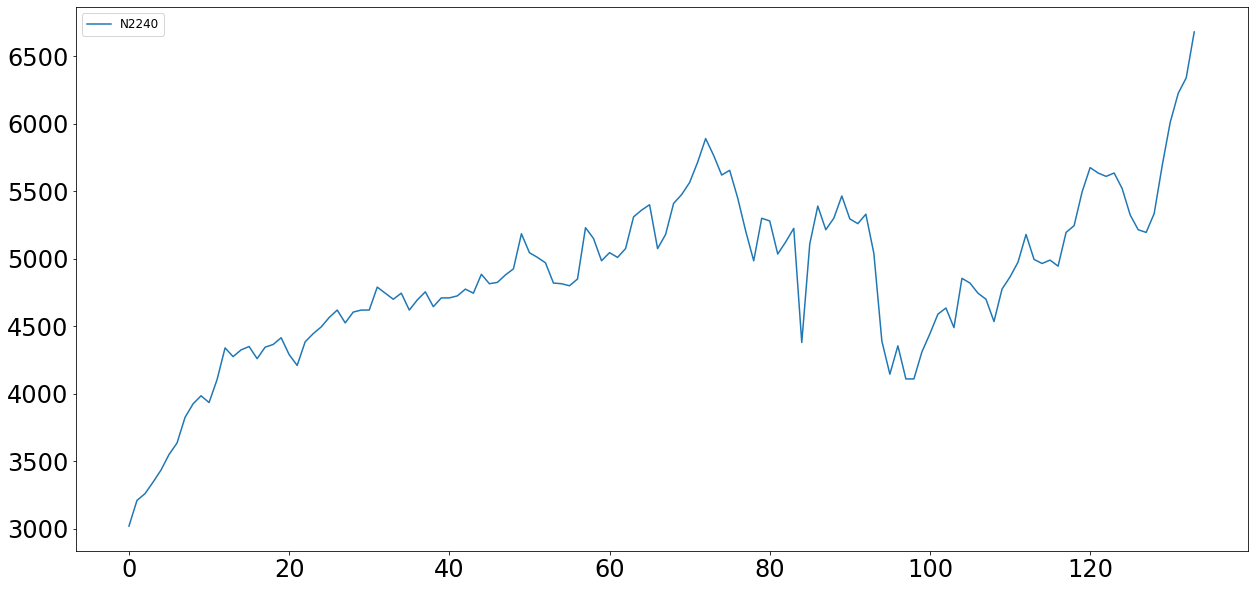

N1848, ADF: False, KPSS: False, seasonal: True


/Users/nick/opt/anaconda3/envs/afe/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


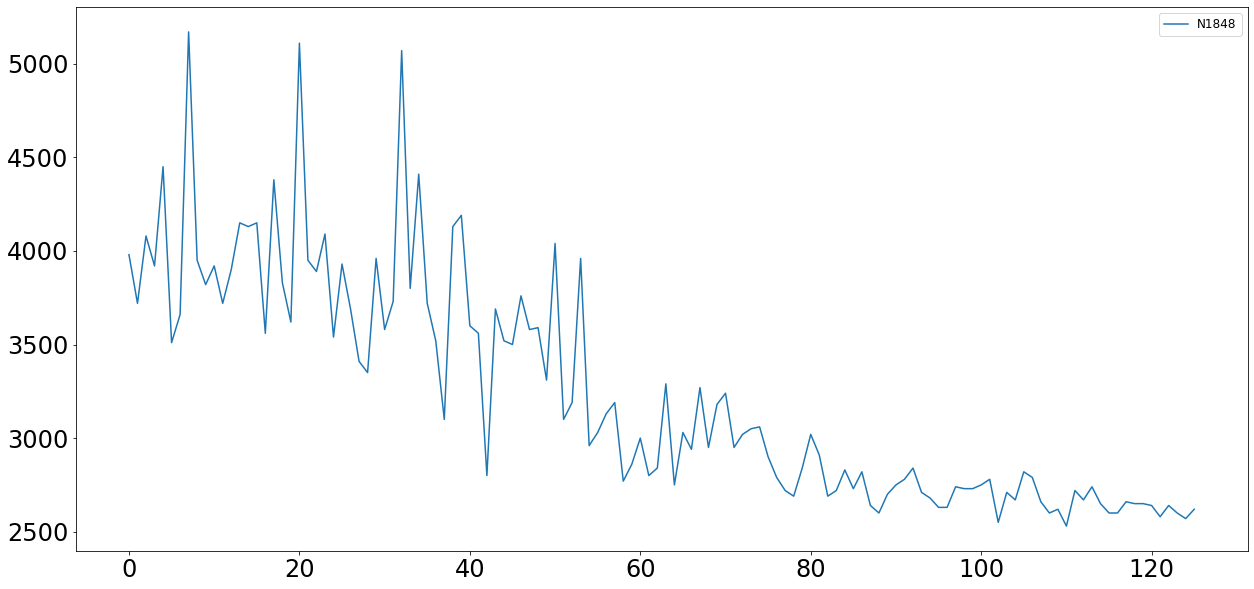

/Users/nick/opt/anaconda3/envs/afe/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


N1762, ADF: False, KPSS: False, seasonal: True


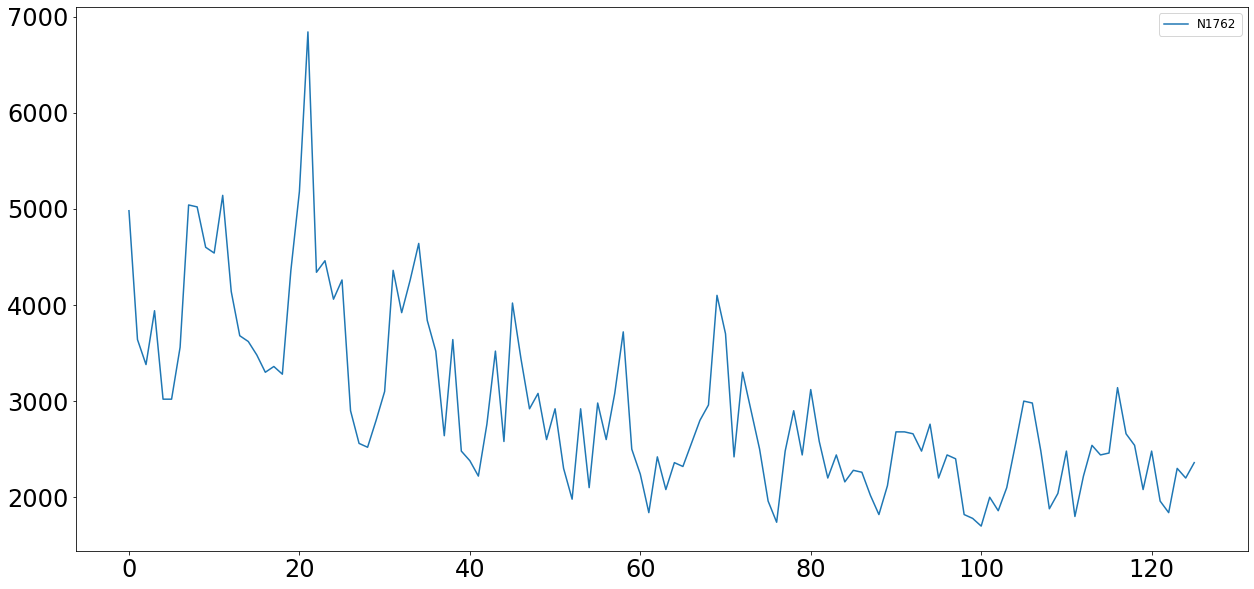

N2638, ADF: False, KPSS: False, seasonal: True


/Users/nick/opt/anaconda3/envs/afe/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


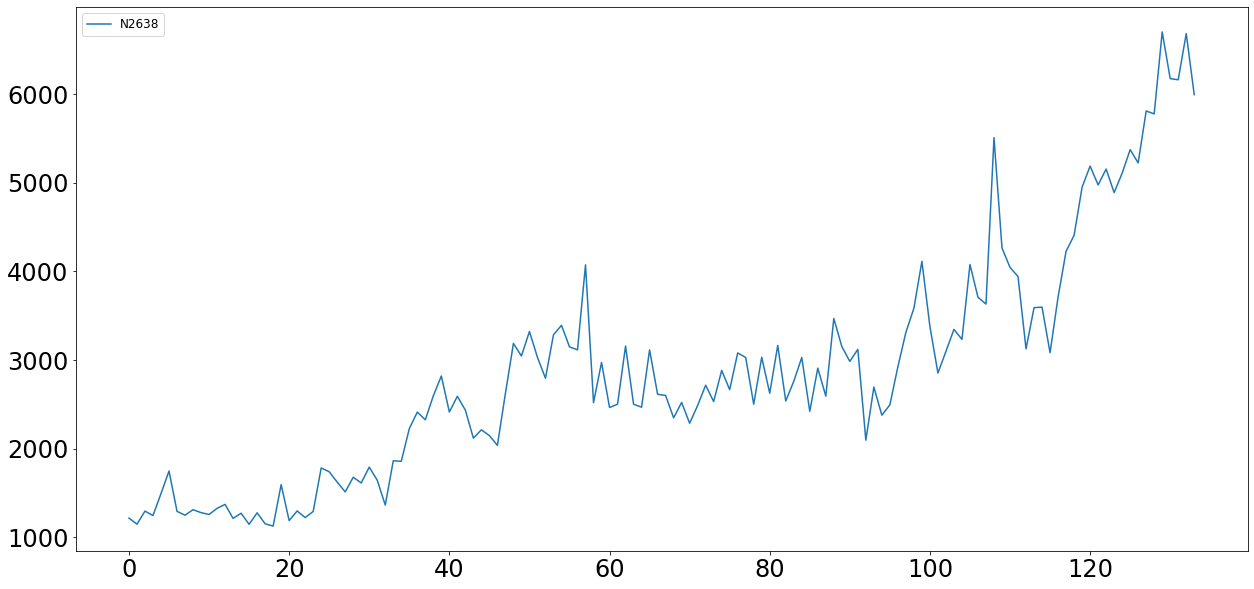

/Users/nick/opt/anaconda3/envs/afe/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


N1748, ADF: False, KPSS: False, seasonal: True


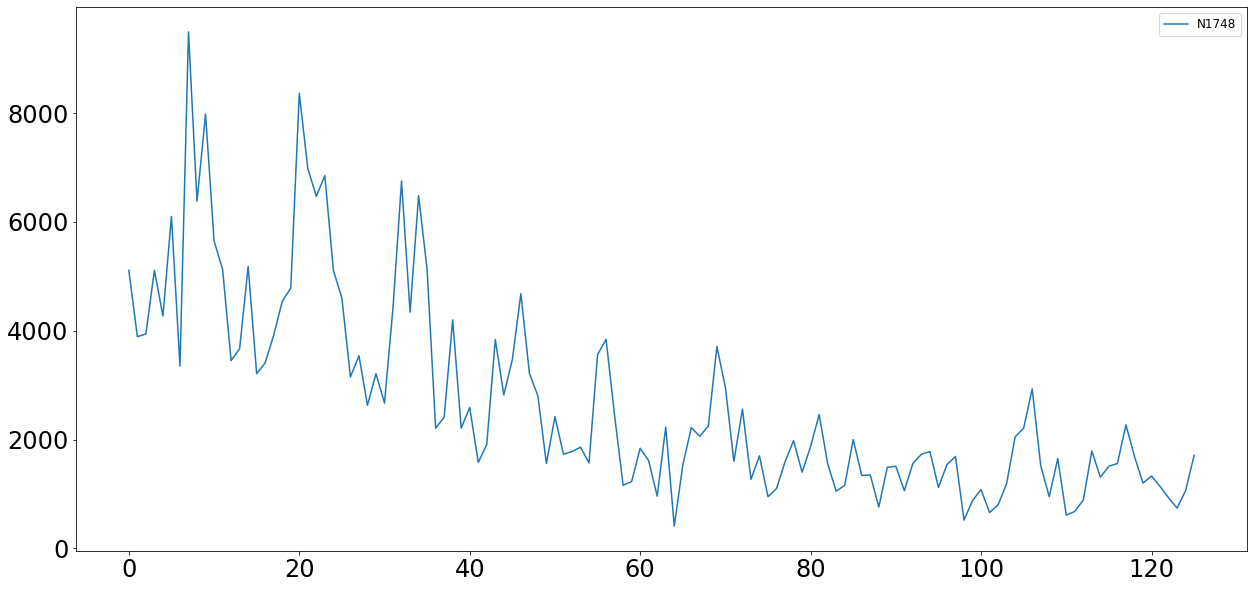

/Users/nick/opt/anaconda3/envs/afe/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


N1958, ADF: False, KPSS: False, seasonal: True


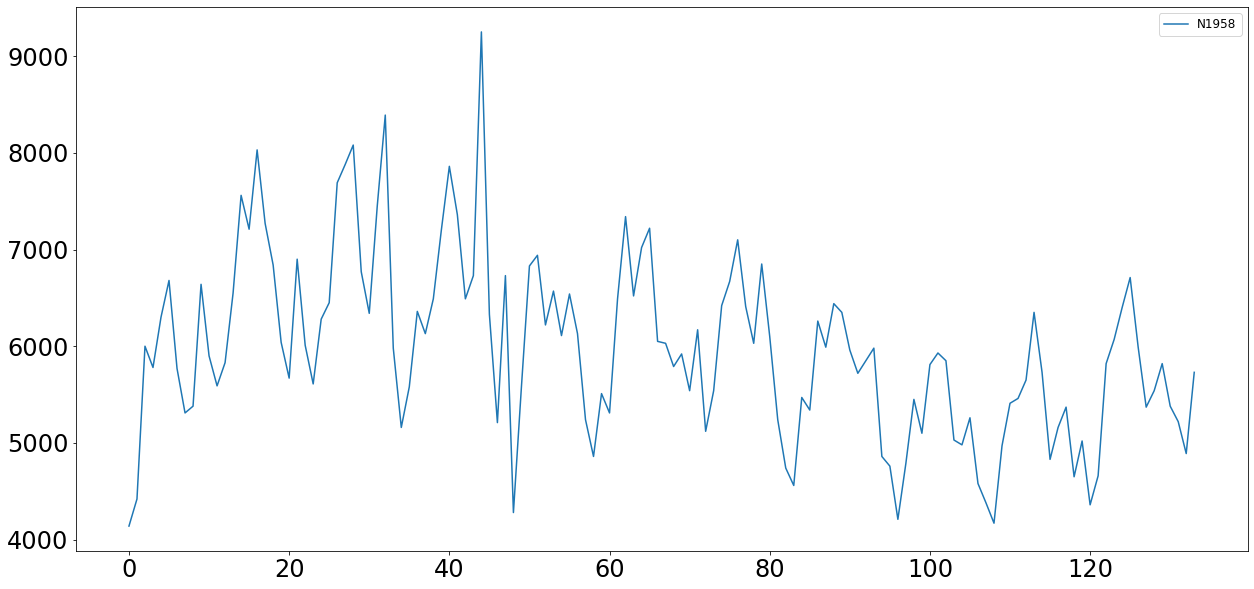

/Users/nick/opt/anaconda3/envs/afe/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


N1701, ADF: False, KPSS: False, seasonal: True


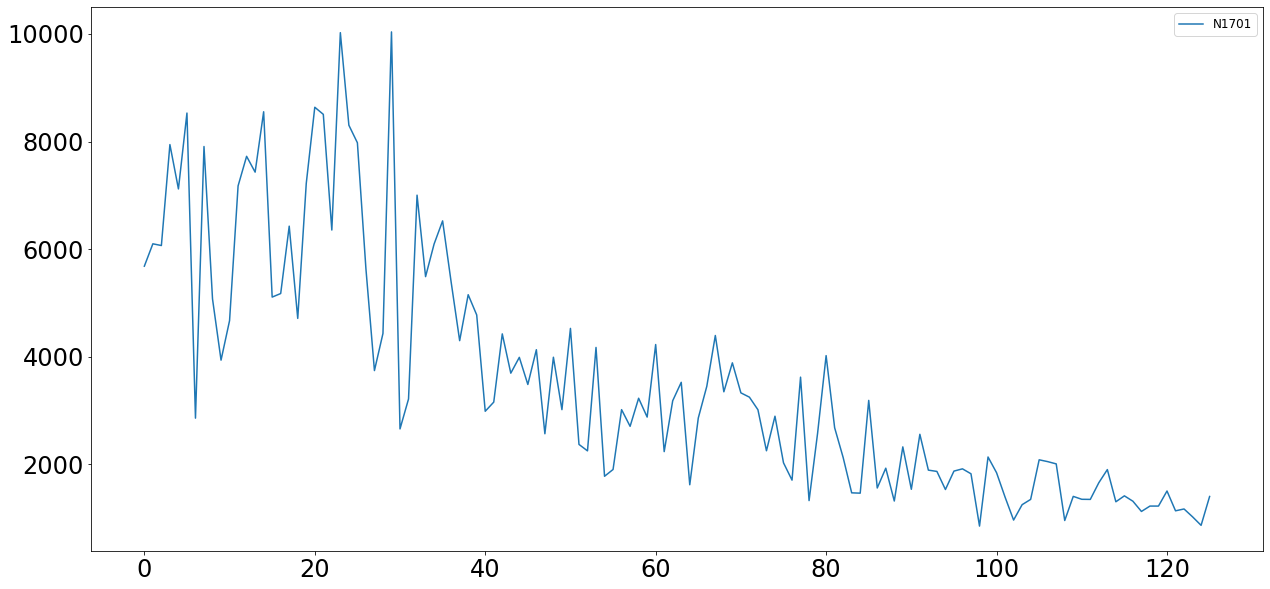

N1782, ADF: False, KPSS: False, seasonal: True


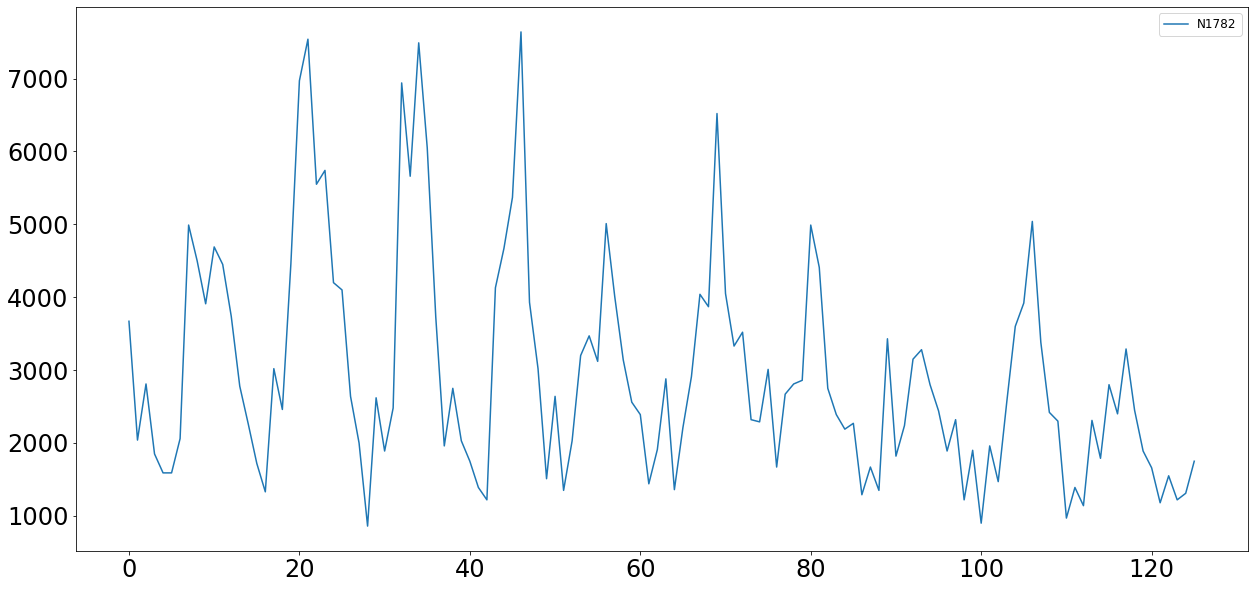

N1737, ADF: False, KPSS: False, seasonal: True


/Users/nick/opt/anaconda3/envs/afe/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


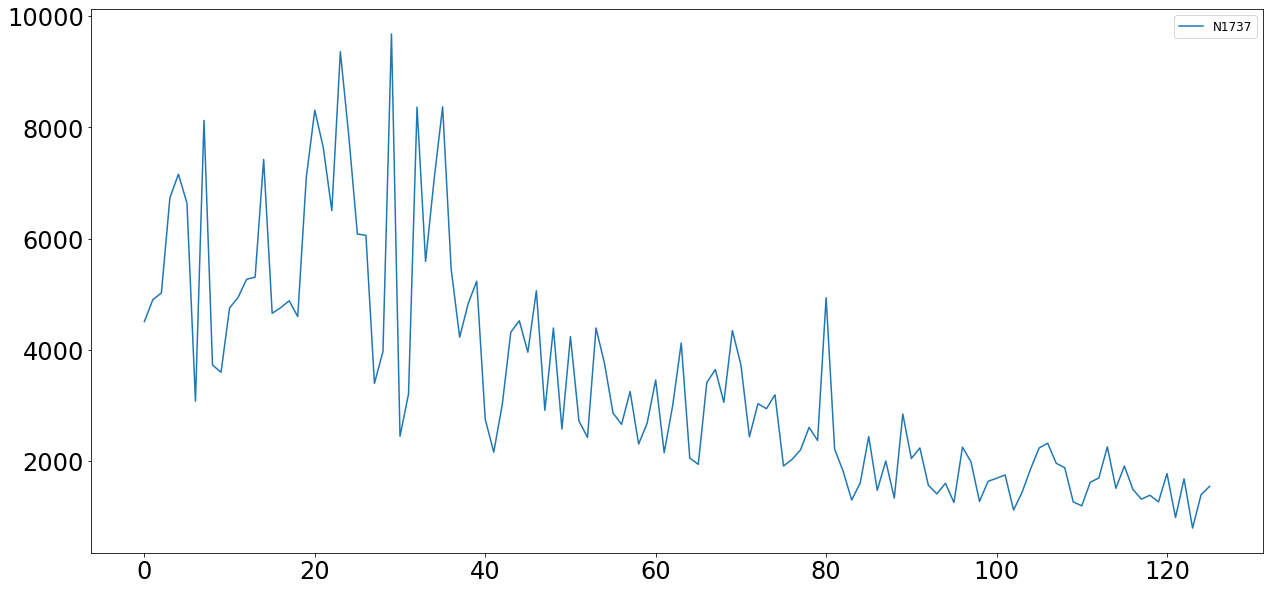

/Users/nick/opt/anaconda3/envs/afe/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


N1869, ADF: False, KPSS: False, seasonal: True


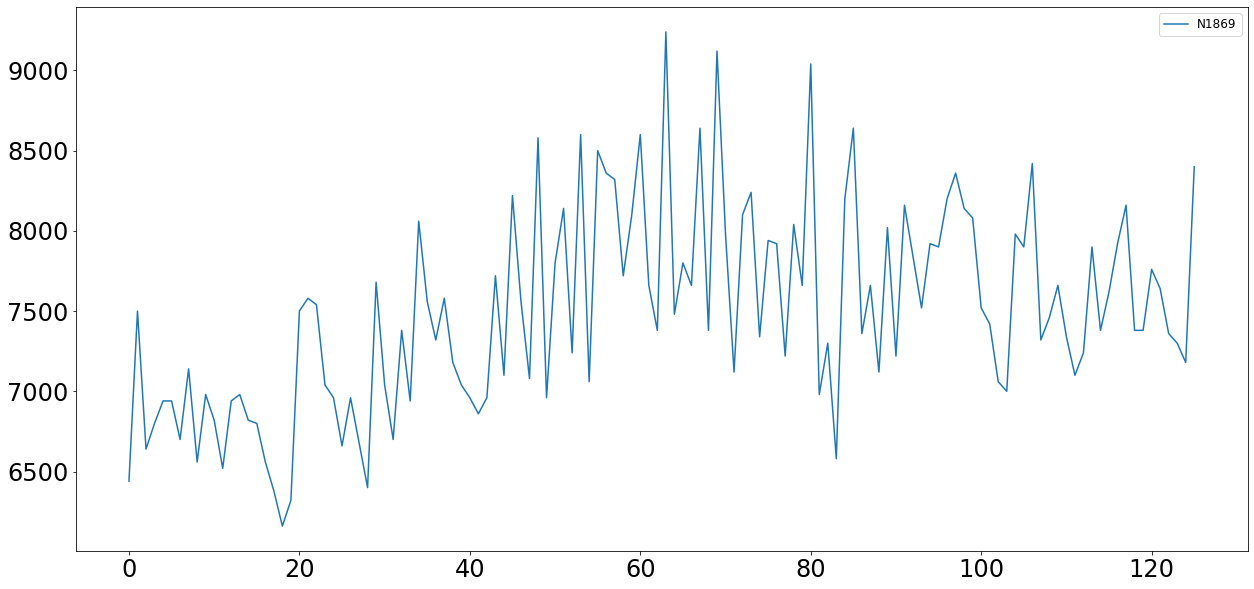

N1766, ADF: False, KPSS: False, seasonal: True


/Users/nick/opt/anaconda3/envs/afe/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


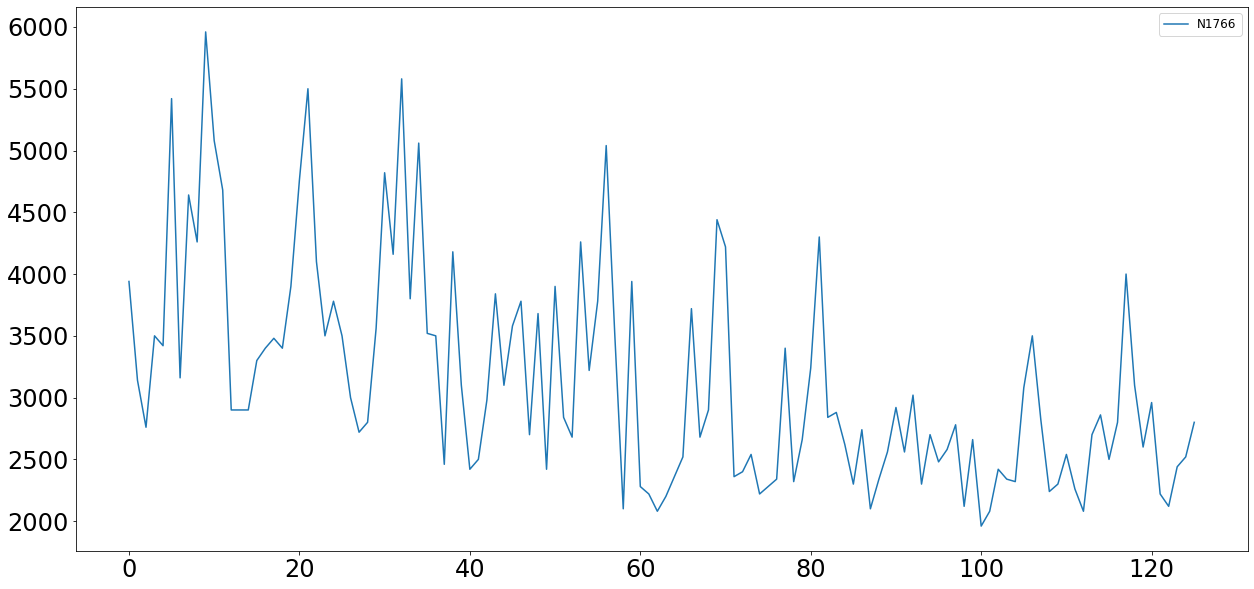

/Users/nick/opt/anaconda3/envs/afe/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


N1757, ADF: False, KPSS: False, seasonal: True


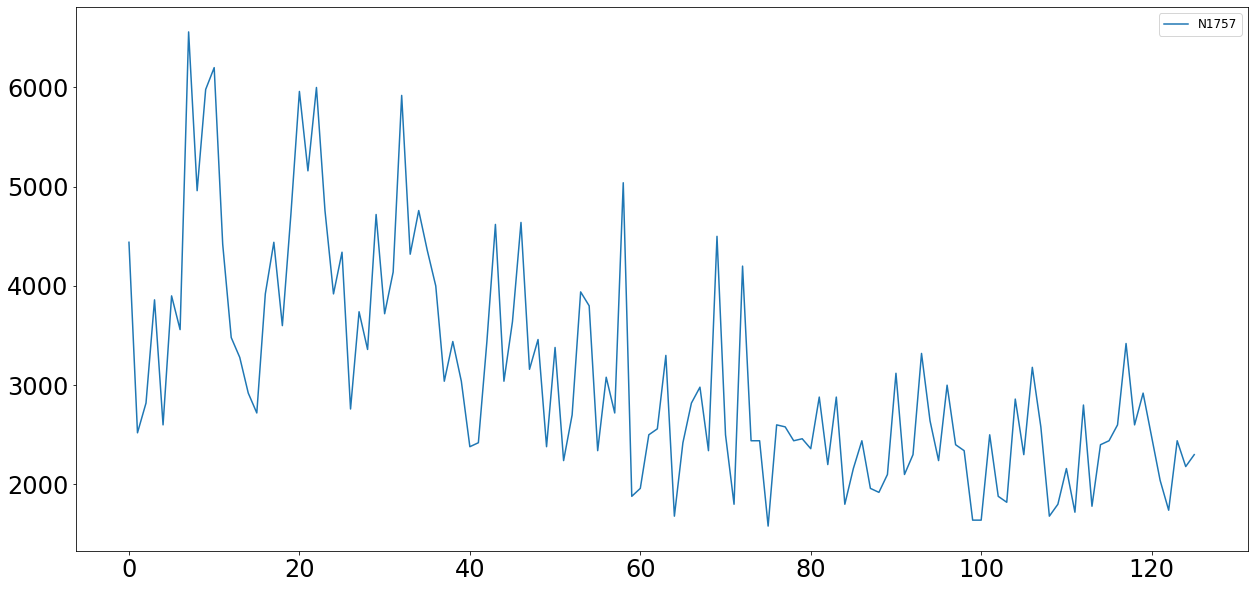

104

In [44]:
from statsmodels.tsa.stattools import adfuller, kpss
ds = DeTrendSeason()
target_idx = list(smape_df[remain].index)

datas = load_m3_data(min_length=100, n_set=5000)
max_len = 0
min_len = 10000
for name, series in datas.items():
    if len(series) > max_len:
        max_len = len(series)
    if len(series) < min_len:
        min_len = len(series)
    if name in target_idx:
        adf = adfuller(series)
        kpsst = kpss(series)
        print(f'{name}, ADF: {adf[0] < adf[4]["5%"]}, KPSS: {kpsst[0] < kpsst[3]["5%"]}, seasonal: {ds.seasonality_test(series, 12)}')
        plt.plot(series, label=name)
        plt.legend()
        plt.show()
max_len
min_len

In [40]:
def ranking():
    ranking = dict()
    frac_best = dict()
    for data in datas:
        for key in ['untransformed', 'transformed']:
            tmp_rank = []
            if data['name'] == 'N1705':
                continue
            for model_name, model_val in data[key].items():
                if model_name not in ranking:
                    ranking[model_name] = dict()
                    frac_best[model_name] = dict()
                if key not in frac_best[model_name]:
                    ranking[model_name][key] = 0
                    frac_best[model_name][key] = 0
                tmp_rank.append((model_name, model_val['symmetric_mean_absolute_percentage_error']))
            rank = sorted(tmp_rank, key=lambda x: x[1])


            for rank_idx in range(len(rank)):
                model_name, _ = rank[rank_idx]
                ranking[model_name][key] += (rank_idx + 1)
                if rank_idx == 0:
                    frac_best[model_name][key] += 1

    df = pd.DataFrame.from_dict(ranking) / len(datas)
    frac_df = pd.DataFrame.from_dict(frac_best) / len(datas) * 100
    df.loc['mean'] = df.mean()
    frac_df.loc['mean'] = frac_df.mean()
    df.index = pd.MultiIndex.from_product([['RANK'], df.index])
    frac_df.index = pd.MultiIndex.from_product([['FRAC-BEST(%)'], frac_df.index])
    return pd.concat([df, frac_df], axis=0)

rf_df = ranking()

TypeError: string indices must be integers

In [ ]:
new_smape = dict()
smape_dict = smape_df.loc['Total'].to_dict()
for (model_name, key), smape in smape_dict.items():
    if model_name not in new_smape:
        new_smape[model_name] = dict()
    if key not in new_smape[model_name]:
        new_smape[model_name][key] = smape

tot_smape_df = pd.DataFrame(new_smape)
tot_smape_df.loc['total'] = tot_smape_df.sum()
tot_smape_df.index = pd.MultiIndex.from_product([['sMAPE'], tot_smape_df.index])

pd.concat([tot_smape_df, rf_df], axis=0)

In [ ]:
def cal_threshold():
    thresholds = dict()
    better_thresholds = dict()
    for data in datas:
        if data['name'] == 'N1705':
            continue
        key = 'transformed'
        for model_name, model_val in data[key].items():
            if model_name not in thresholds:
                thresholds[model_name] = dict()
                better_thresholds[model_name] = dict()
            if model_val['threshold'] not in thresholds[model_name]:
                thresholds[model_name][model_val['threshold']] = 0
                better_thresholds[model_name][model_val['threshold']] = 0

            thresholds[model_name][model_val['threshold']] += 1
            if model_val['symmetric_mean_absolute_percentage_error'] < data['untransformed'][model_name]['symmetric_mean_absolute_percentage_error']:
                better_thresholds[model_name][model_val['threshold']] += 1
        
    df = pd.DataFrame.from_dict(thresholds).sort_index().fillna(0).astype(int)
    df['Total'] = df.sum(axis=1)
    df.loc['Total'] = df.sum(axis=0)
    df.index = pd.MultiIndex.from_product([['Optimal Threshold'], df.index])

    better_df = pd.DataFrame.from_dict(better_thresholds).sort_index().fillna(0).astype('object')
    better_df.loc['Total(%)'] = better_df.sum(axis=0) / len(datas) * 100
    better_df['Total(%)'] = round(better_df.sum(axis=1) / df['Total'].values * 100)
    better_df.index = pd.MultiIndex.from_product([['Better than raw data'], better_df.index])
    return df.T, better_df.astype(int).T

df, better_df = cal_threshold()
df

In [ ]:
better_df.iloc[-1,-1] = np.nan
better_df

In [ ]:
def cal_lag(index='lags'):
    lags = dict()
    for data in datas:
        if data['name'] == 'N1705':
            continue
        for key in ['untransformed', 'transformed']:
            for model_name, model_val in data[key].items():
                if model_name in ['AutoETS', 'NaiveForecaster']:
                    continue
                if model_name not in lags:
                    lags[model_name] = dict()
                if key not in lags[model_name]:
                    lags[model_name][key] = dict()
                if model_val[index] not in lags[model_name][key]:
                    lags[model_name][key][model_val[index]] = 0

                lags[model_name][key][model_val[index]] += 1
    reform = {(outerKey, innerKey): values for outerKey, innerDict in lags.items() for innerKey, values in dict(innerDict).items()}
    df = pd.DataFrame(reform).sort_index().fillna(0).astype(int)
    # df.drop(index='AutoETS', inplace=True)
    df['Total'] = df.sum(axis=1)
    df.index = pd.MultiIndex.from_product([['Lag'], df.index])
    return df.T

df = cal_lag(index='lags')
df

In [ ]:
df = pd.concat([list(df.groupby(level=1))[1][1].sum(), list(df.groupby(level=1))[2][1].sum()], axis=1).T.astype(int)
df.index = ['transformed(sum)', 'untransformed(sum)']
df

In [ ]:
plot_prediction(datas, model='GRU', only_test=False)

In [ ]:
plot_log_prediction(datas, model='GRU')

In [ ]:
plot_prediction(datas, model='ElasticNet', only_test=False)

In [ ]:
plot_log_prediction(datas, model='ElasticNet')

In [ ]:
plot_prediction(datas, model='KNeighborsRegressor', only_test=False)

In [ ]:
plot_log_prediction(datas, model='KNeighborsRegressor')

In [ ]:
plot_prediction(datas, model='MLPRegressor', only_test=False)

In [ ]:
plot_log_prediction(datas, model='MLPRegressor')

In [ ]:
plot_prediction(datas, model='AutoETS', only_test=False)

In [ ]:
plot_log_prediction(datas, model='AutoETS')

In [ ]:
plot_prediction(datas, model='RandomForestRegressor', only_test=False)

In [ ]:
plot_log_prediction(datas, model='RandomForestRegressor')

In [ ]:
plot_prediction(datas, model='LinearSVR', only_test=False)

In [ ]:
plot_log_prediction(datas, model='LinearSVR')

In [ ]:
plot_prediction(datas, model='LSTM')

In [ ]:
plot_log_prediction(datas, model='LSTM')

In [ ]:
plot_prediction(datas, model='NaiveForecaster', only_test=False)

In [ ]:
plot_log_prediction(datas, model='NaiveForecaster')

In [ ]:


# smape_df.columns = [f'{m}({t[0]})' for m, t in smape_df.columns]
print([f'{m}({t[0]})' for m, t in smape_df.columns])
smape_df.columns = ['EN(u)', 'EN(t)', 'SVR(u)', 'SVR(t)', 'KNN(u)', 'KNN(t)', 'RF(u)', 'RF(t)', 'MLP(u)', 'MLP(t)', 'ETS(u)', 'ETS(t)', 'Naive(u)', 'Naive(t)']
# smape_df.columns = ['GRU(u)', 'GRU(t)', 'ETS(u)', 'ETS(t)', 'Naive(u)', 'Naive(t)']
# smape_df.columns = ['EN(u)', 'EN(t)', 'MLP(u)', 'MLP(t)', 'GRU(u)', 'GRU(t)', 'ETS(u)', 'ETS(t)']
smape_df.iloc[:-1,].boxplot(grid=False, showfliers=False, showmeans=True, rot=80, medianprops=dict(linewidth=2.5), capprops=dict(linewidth=2.5))
plt.ylabel('sMAPE')